In [29]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
import torch.optim as optim
from script.tools import tools
from script.collection import Parameter as pmt
import sys
print(sys.executable)
import net
import os
from script.tools import collection
result = collection.collection("collection/workspace1")  #[iops,dic_ssd,dic_worload,f.path]
result = collection.collection("collection/workspace2",result)
plst = collection.getParameters(path="collection/config.xlsx")



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/opt/homebrew/anaconda3/bin/python
collection:  472
collection:  1774


/opt/homebrew/anaconda3/lib/python3.9/site-packages/openpyxl/reader/excel.py:237: UserWarning: Data Validation extension is not supported and will be removed
  ws_parser.bind_all()


In [65]:
xlst = []
ylst = []
xylst = []
keys = []
expect = ['Seed','key','default']
for iops,dic_ssd,dic_worload,path in result:
    dic = dic_ssd
    dic.update(dic_worload)
    values,keys = collection.getUsefullKeys(dic,plst,expect)
    if iops == 'inf':
        print("inf------")
        continue
    xlst.append(values)
    ylst.append([float(iops)])
    xylst.append([values,[float(iops)]])
    keys = keys
print(len(xlst)," ",len(ylst))
print(len(xlst[0]))
print(keys)
#print(ylst)

inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
inf------
1714   1714
47
['PCIe_Lane_Count', 'SATA_Processing_Delay', 'Queue_Fetch_Size', 'Data_Cache_DRAM_Row_Size', 'Data_Cache_DRAM_Data_Rate', 'Data_Cache_DRAM_Data_Busrt_Size', 'Data_Cache_DRAM_tRCD', 'Data_Cache_DRAM_tCL', 'Data_Cache_DRAM_tRP', 'Overprovisioning_Ratio', 'GC_Exec_Threshold', 'Preferred_suspend_erase_time_for_read', 'Preferred_suspend_erase_time_for_write', 'Preferred_suspend_write_tim

In [126]:
x_tensor = torch.tensor(xlst,dtype=torch.float)
y_tensor = torch.tensor(ylst,dtype=torch.float)
print(x_tensor.size(),y_tensor.size())
#x_ytensor = torch.tensor(xylst,dtype=torch.float)


# 计算均值和标准差
x_mean = x_tensor.mean(dim=0)
x_std = x_tensor.std(dim=0)
y_mean = y_tensor.mean(dim=0)
y_std = y_tensor.std(dim=0)

# 归一化 x 和 y
normalized_x = (x_tensor - x_mean) / x_std
normalized_y = (y_tensor - y_mean) / y_std
print("x_mean: ",x_mean)
print("x_std: ",x_std)
print("y_mean: ",y_mean)
print("y_std: ",y_std)

def out(y):
    return y*y_std + y_mean


torch.Size([1714, 47]) torch.Size([1714, 1])
x_mean:  tensor([2.0126e+01, 2.0256e+06, 2.5827e+03, 4.0766e+04, 5.0314e+02, 5.5753e+00,
        6.5455e+01, 6.4979e+01, 6.4945e+01, 1.8852e-01, 2.5609e-01, 3.6033e+06,
        3.5069e+06, 5.0797e+05, 1.3387e+01, 5.5554e+00, 1.6994e+03, 8.7007e+00,
        3.8038e+05, 3.8117e+05, 3.8545e+05, 3.8317e+06, 3.7912e+06, 3.8314e+06,
        1.9040e+07, 4.9756e+04, 3.5563e+06, 5.0236e+05, 7.4224e+00, 7.8232e+00,
        4.3896e+03, 5.1447e+02, 1.6668e+04, 2.2411e+03, 1.6327e+21, 3.8614e+09,
        2.9822e+07, 3.1882e+07, 5.0019e+01, 4.9661e+01, 4.8381e+01, 5.0604e+01,
        7.9946e+01, 4.0094e+01, 4.8835e+02, 8.3526e+01, 1.6725e+05])
x_std:  tensor([1.1233e+01, 1.1282e+06, 1.4680e+03, 2.3436e+04, 2.8501e+02, 2.9105e+00,
        3.7692e+01, 3.7968e+01, 3.7416e+01, 1.5028e-01, 1.4447e-01, 2.0143e+06,
        2.0214e+06, 2.8218e+05, 1.7306e+01, 2.8703e+00, 9.4076e+02, 9.2861e+00,
        2.1536e+05, 2.1238e+05, 2.1598e+05, 2.1459e+06, 2.1499e+06, 2

In [117]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
# 自定义数据集类
class CustomDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# dataset = CustomDataset(x_tensor, y_tensor)
dataset = CustomDataset(normalized_x, normalized_y)

batch_size = 16
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = net.DeepNet(47,20,1,3)
criterion = nn.MSELoss()
#optimizer = optim.SGD(model.parameters(), lr=0.001)
optimizer = optim.Adam(model.parameters(), lr=0.001)



In [123]:
num_epochs = 500
i = 0
loss_history = []
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_x, batch_y in dataloader:
        #i = i +1
        #print(batch_x,"\n",batch_y)
        #print("zzzzzzz")
        # 前向传播
        outputs = model(batch_x)
        #print("batch_x",batch_x[0],"\n outputs: ",outputs[0])
        loss = criterion(outputs, batch_y)
        total_loss += loss.item()

        #print("loss:",loss.item(),"batch_x: ",batch_x," outputs ",outputs," batch_y: ",batch_y)
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    loss_history.append(total_loss)
    # 打印训练信息
    if (epoch+1) % 10 == 0:
        average_loss = total_loss / len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}')



Epoch [10/500], Loss: 0.0014
Epoch [20/500], Loss: 0.0080
Epoch [30/500], Loss: 0.0037
Epoch [40/500], Loss: 0.0026
Epoch [50/500], Loss: 0.0042
Epoch [60/500], Loss: 0.0031
Epoch [70/500], Loss: 0.0094
Epoch [80/500], Loss: 0.0103
Epoch [90/500], Loss: 0.0077
Epoch [100/500], Loss: 0.0052
Epoch [110/500], Loss: 0.0013
Epoch [120/500], Loss: 0.0018
Epoch [130/500], Loss: 0.0040
Epoch [140/500], Loss: 0.0016
Epoch [150/500], Loss: 0.0048
Epoch [160/500], Loss: 0.0048
Epoch [170/500], Loss: 0.0049
Epoch [180/500], Loss: 0.0047
Epoch [190/500], Loss: 0.0047
Epoch [200/500], Loss: 0.0017
Epoch [210/500], Loss: 0.0120
Epoch [220/500], Loss: 0.0019
Epoch [230/500], Loss: 0.0043
Epoch [240/500], Loss: 0.0039
Epoch [250/500], Loss: 0.0024
Epoch [260/500], Loss: 0.0047
Epoch [270/500], Loss: 0.0041
Epoch [280/500], Loss: 0.0037
Epoch [290/500], Loss: 0.0030
Epoch [300/500], Loss: 0.0023
Epoch [310/500], Loss: 0.0013
Epoch [320/500], Loss: 0.0012
Epoch [330/500], Loss: 0.0085
Epoch [340/500], Lo

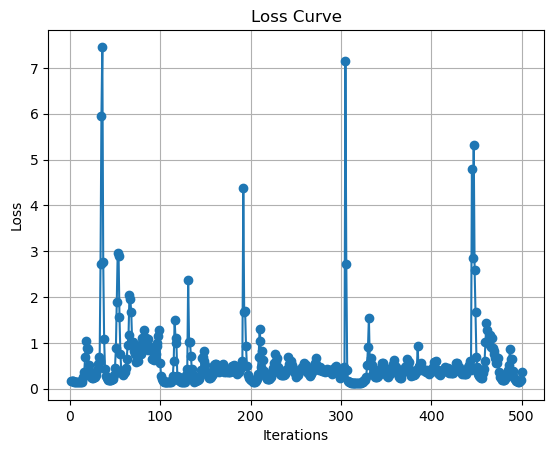

In [124]:
import matplotlib.pyplot as plt

# 假设你有一个名为 "loss_history" 的列表，其中包含了每个训练迭代的损失值
#loss_history = [0.5, 0.4, 0.3, 0.2, 0.1]

# 创建 x 轴的数据，表示训练迭代的次数
iterations = range(1, len(loss_history) + 1)

# 绘制 loss 的变化图
plt.plot(iterations, loss_history, marker='o')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.grid(True)
plt.show()